In [20]:
import cv2
import sys
import os
import numpy as np
from numpy import *
import rasterio
from osgeo import gdal
from skimage import filters
from skimage import exposure
from osgeo.gdalconst import *
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
from sklearn.preprocessing import minmax_scale

import skimage
from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize 

In [41]:
file = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\DJI.jpg' #location of file

In [42]:
img = gdal.Open(file, gdal.GA_ReadOnly)

gtr = img.GetGeoTransform()
dvr = img.GetDriver()
col = img.RasterXSize
row = img.RasterYSize
bnd = img.RasterCount
prj = img.GetProjection()

In [51]:
array = []
for b in range(bnd+1)[1::]:
    band = img.GetRasterBand(b)
    arry = band.ReadAsArray().astype(np.float32)
    mask = np.logical_not(np.ma.masked_invalid(arry))
    array.append(mask)
    del band, arry, mask

array = np.dstack([array])
b, w, h, = array.shape
array = np.moveaxis(array, 0, 2)
gray = skimage.color.rgb2gray(array)
radius = 3
points = 1*radius
lbp = local_binary_pattern(gray, points, radius, method='uniform')
#array.shape
#mask = np.moveaxis(mask, 0, 2).reshape(w*h,t*b)

#plt.imshow(gray, cmap=plt.cm.gray)
#plt.title("Grayscale")

Text(0.5, 1.0, 'Grayscale')

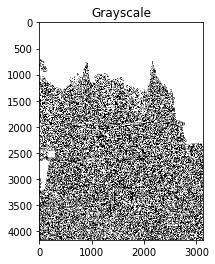

In [53]:
plt.imshow(lbp, cmap='gray')
plt.title("Grayscale")

In [378]:
df = pd.DataFrame(array.reshape(w*h))
df_ = df.dropna()

In [379]:
# Otsu's thresholding
val = filters.threshold_otsu(np.float32(df_)) #otsu threshold
hist, bins_center = exposure.histogram(np.float32(df_)) #histogram

c:\users\envisagepc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


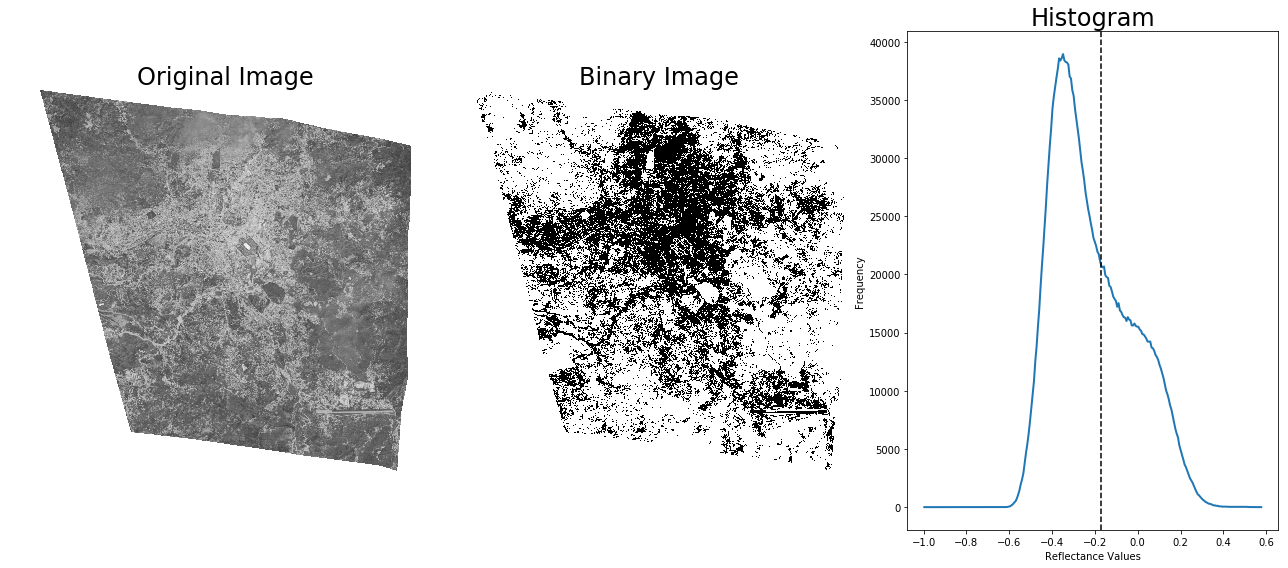

In [380]:
plt.figure(figsize=(18, 8))
plt.subplot(131)
plt.title('Original Image', fontsize=24)
plt.imshow(array, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(132)
plt.title('Binary Image', fontsize=24)
plt.imshow(array < val, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')
plt.title('Histogram', fontsize=24)
plt.xlabel('Reflectance Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [381]:
print ('Value of Threshold: ', val)

Value of Threshold:  -0.16986665


In [353]:
mask = array > val #or img_scaled < val (depending what to mask)
tiff = array*mask

c:\users\envisagepc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [354]:
driver = img.GetDriver()
outputPath = os.getcwd()
columns2Ras = 'IMG'
ns = driver.Create(os.path.join(outputPath,'%s_threshold.tif'%(columns2Ras)),\
                      col,row,1,GDT_Float32)
ns.SetGeoTransform(gtr) 
ns.SetProjection(prj)
outputRas = ns.GetRasterBand(1)
outputRas.WriteArray(mask,0,0)
ns.FlushCache()
outputRas.FlushCache()
del outputRas,ns